The type of Neural Network designed to handle sequence dependence is called recurrent neural networks(RNN). 

The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['prices.csv', 'securities.csv', 'prices-split-adjusted.csv', 'fundamentals.csv']


In [2]:
data_df =  pd.read_csv("../input/prices-split-adjusted.csv", index_col = 0)
data_df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
df2 = pd.read_csv("../input/fundamentals.csv")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,1.049900e+10,78.0,0.000000e+00,223000000.0,1.001000e+09,-1.813000e+09,-2.445000e+09,0.0,0.0,1.340200e+10,0.000000e+00,58.0,1.435600e+10,-5.690000e+08,8.690000e+08,632000000.0,5.800000e+08,3.060000e+08,4.730000e+08,7.116000e+09,0.0,0.0,0.0,-1.020000e+09,197000000.0,1.285000e+09,4.830000e+08,-1.571000e+09,-1.876000e+09,2.050000e+09,-1.876000e+09,-4.084000e+09,1.124000e+09,3.860000e+08,1.480000e+08,1.0,2.167000e+09,6.260000e+08,4.524000e+09,-2.980000e+09,1.509000e+09,11000000.0,1.514700e+10,-141000000.0,8.450000e+08,10.0,31.0,8.0,72.0,0.0,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,1.101900e+10,104.0,0.000000e+00,935000000.0,1.020000e+09,-1.324000e+09,-2.180000e+09,0.0,0.0,1.925900e+10,4.086000e+09,59.0,1.572400e+10,-3.460000e+08,2.311000e+09,856000000.0,1.012000e+09,-1.181000e+09,-2.350000e+08,1.535300e+10,0.0,0.0,0.0,2.208000e+09,660000000.0,6.750000e+08,3.799000e+09,-3.814000e+09,-1.834000e+09,1.873000e+09,-1.834000e+09,-4.489000e+09,1.560000e+09,5.590000e+08,1.399000e+09,5.0,2.299000e+09,1.465000e+09,7.385000e+09,-2.032000e+09,1.711000e+09,481000000.0,1.491500e+10,-56000000.0,8.530000e+08,8.0,80.0,7.0,96.0,0.0,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,1.562000e+10,88.0,0.000000e+00,829000000.0,1.342000e+09,4.099000e+09,3.212000e+09,0.0,0.0,2.308400e+10,4.091000e+09,63.0,2.703000e+10,3.300000e+08,2.240000e+09,887000000.0,1.004000e+09,1.799000e+09,-1.026000e+09,1.604300e+10,0.0,0.0,0.0,1.700000e+08,-146000000.0,3.080000e+09,-3.150000e+08,-2.911000e+09,2.882000e+09,5.420000e+08,2.882000e+09,2.882000e+09,1.771000e+09,8.000000e+08,4.249000e+09,10.0,2.060000e+09,8.980000e+08,7.059000e+09,-4.559000e+09,8.170000e+08,601000000.0,1.092800e+10,-500000000.0,1.295000e+09,8.0,159.0,7.0,80.0,0.0,-8.562000e+09,-1.052000e+09,2.068600e+10,1.677000e+09,6.309000e+09,4.322

I am extracting the apple stocks only: AAPL

In [4]:
data_df = data_df[data_df.symbol == 'AAPL']
data_df.drop(['symbol'],1,inplace=True)
data_df.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0


In [5]:
data_df.shape

(1762, 5)

In [6]:
data_df.tail()

,open,close,low,high,volume
date,,,,,
2016-12-23,115.589996,116.519997,115.589996,116.519997,14249500.0
2016-12-27,116.519997,117.260002,116.489998,117.800003,18296900.0
2016-12-28,117.519997,116.760002,116.199997,118.019997,20905900.0
2016-12-29,116.449997,116.730003,116.400002,117.110001,15039500.0
2016-12-30,116.650002,115.820000,115.430000,117.199997,30586300.0


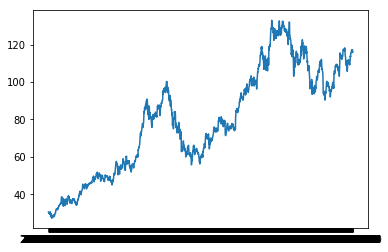

In [7]:
plt.plot(data_df['close'])
plt.show()

In [8]:
data_df['date'] = data_df.index
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0,2010-01-04
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0,2010-01-05
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0,2010-01-06
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0,2010-01-07
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0,2010-01-08


In [9]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [10]:
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0,2010-01-04
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0,2010-01-05
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0,2010-01-06
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0,2010-01-07
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0,2010-01-08


> LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. 

In [11]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['close'].values.reshape(-1, 1))

In [12]:
dataset[0:10]

array([[0.02971784],
       [0.03021854],
       [0.02560389],
       [0.02507612],
       [0.0269707 ],
       [0.02444008],
       [0.02120576],
       [0.02517085],
       [0.02351986],
       [0.0187834 ]])

In [13]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1233 529


In [14]:
print(len(data_df))
print(1233 + 529)

1762
1762


I set the look back date as 15 days, which is the number of previous time steps to use as input variables to predict the next time period

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1217, 15)
(1217,)
(513, 15)
(513,)


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, this data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [18]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1217, 1, 15)
(1217,)
(513, 1, 15)
(513,)


**LSTM**

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

* Forget Gate: conditionally decides what information to throw away from the block.
* Input Gate: conditionally decides which values from the input to update the memory state.
* Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

>The network has a visible layer with 1 input, a hidden layer with 20 LSTM blocks or neurons, and an output layer that makes a 15 value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 20 epochs and a batch size of 1 is used.

In [20]:
# create and fit the LSTM network
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
 - 9s - loss: 0.0025
Epoch 2/20
 - 8s - loss: 5.7900e-04
Epoch 3/20
 - 8s - loss: 4.4811e-04
Epoch 4/20
 - 8s - loss: 3.8554e-04
Epoch 5/20
 - 8s - loss: 3.5934e-04
Epoch 6/20
 - 8s - loss: 3.4425e-04
Epoch 7/20
 - 8s - loss: 3.3990e-04
Epoch 8/20
 - 8s - loss: 2.9196e-04
Epoch 9/20
 - 8s - loss: 2.9474e-04
Epoch 10/20
 - 8s - loss: 2.6881e-04
Epoch 11/20
 - 8s - loss: 2.8864e-04
Epoch 12/20
 - 8s - loss: 2.8338e-04
Epoch 13/20
 - 8s - loss: 2.6375e-04
Epoch 14/20
 - 8s - loss: 2.7269e-04
Epoch 15/20
 - 8s - loss: 2.3640e-04
Epoch 16/20
 - 8s - loss: 2.4269e-04
Epoch 17/20
 - 8s - loss: 2.1706e-04
Epoch 18/20
 - 8s - loss: 2.2666e-04
Epoch 19/20
 - 8s - loss: 2.2937e-04
Epoch 20/20
 - 8s - loss: 2.1948e-04


In [21]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.69 RMSE
Test Score: 2.92 RMSE


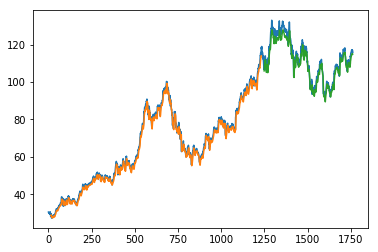

In [22]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

>reference: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/